# Shared Species Richness

This notebook illustrates the use of the (unobserved) shared species richness estimator (`chao-shared`) included in the `copia` package. It documents the same example application that is used as a unit test in the package (see `tests/test_shared.py`). Accessible introductions to this problem are available in:
> - Chao, Anne, et al., Deciphering the Enigma of Undetected Species, Phylogenetic, and Functional Diversity Based on Good-Turing Theory. *Ecology* (2017), 2914-2929 [[doi]](https://doi.org/10.1002/ecy.2000).

> - Karsdorp, F, 'Estimating Unseen Shared Cultural Diversity' (2022) [[blog post]](https://web.archive.org/web/20220526135551/https://www.karsdorp.io/posts/20220316142536-two_assemblage_good_turing_estimation). 

We use some ecological example data, where the overlap in species richness was studied in two samples of trees. This data (tree species abundance counts for the edge and interior habitats in forest fragments of south-eastern Brazil) are borrowed from study:

> Magnago, L. F. S., D. P. Edwards, F. A. Edwards, A. Magrach, S. V. Martins, and W. F. Laurance. 2014. Functional attributes change but functional richness is unchanged after fragmentation of Brazilian Atlantic forests. *Journal of Ecology* (2014), 475−485 [[doi]](http://dx.doi.org/10.1111/1365-2745.12206).

This data was downloaded from Anne Chao's [Github page](https://raw.githubusercontent.com/AnneChao/Good-Turing/refs/heads/master/DataS1%20(abundance%20data).txt) and is included in the `copia` repository. We can load it as follows:

In [1]:
import pandas as pd
trees = pd.read_csv('../datasets/trees.csv', header=0, sep=' ').reset_index(drop=True)
trees.columns = ['s1', 's2']
trees = trees.reset_index(names=['species'])
trees['s1'] = trees['s1'].astype(int) # Edge trees
trees['s2'] = trees['s2'].astype(int) # Interior trees

trees.sample(5)

,species,s1,s2
213,213,1,0
210,210,16,20
33,33,2,1
342,342,0,3
70,70,0,1


Note that we need two, perfectly aligned counts of species in two assemblages that show partial overlap in their species richness. Because we need to preserve this overlap, we need to add an extra argument (`remove_zeros=False`) when converting each vector to a copia dataset:

In [2]:
from copia.data import to_copia_dataset

s1 = to_copia_dataset(trees, data_type='abundance', input_type='counts',
                          index_column='species', count_column='s1', remove_zeros=False)
s2 = to_copia_dataset(trees, data_type='abundance', input_type='counts',
                          index_column='species', count_column='s2', remove_zeros=False)

/Users/mikekestemont/miniconda3/envs/copia/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This ensures that the resulting counts in each dataset can still be aligned, which is crucial for the estimator to function properly:

In [3]:
len(s1.counts) == len(s2.counts)

True

We can verify the basic integrity of the data by comparing our basic statistics to those reported in Chao et al. (2017):

In [4]:
assert s1.S_obs == 319
assert s1.f1 == 110
assert s1.f2 == 48
assert s1.n == 1794

assert s2.S_obs == 356
assert s2.f1 == 123
assert s2.f2 == 48
assert s2.n == 2074

We can now apply the `chao-shared` estimator. First, we have a look at the plain point estimates, without any confidence intervals:

In [5]:
import copia
without_ci = copia.estimators.chao_shared(s1, s2, CI=False)
without_ci

{'total': np.float64(389.15351223662145),
 'obs_shared': np.float64(250.0),
 'unobs_shared': np.float64(139.15351223662142),
 'f0+': np.float64(48.62153123022688),
 'f+0': np.float64(68.2337512054002),
 'f00': np.float64(22.29822980099436)}

A results `dict` is returned containing (unrounded) floats for all of the (estimated) quantities that are relevant to this problem:
- $f_{00}$: number of species estimated to be shared by the two assemblages, but observable in neither of the samples;
- $f_{0+}$: number of species estimated to be shared by the two assemblages, but only observed in the 2nd sample;
- $f_{+0}$: number of species estimated to be shared by the two assemblages, but only observed in the 1nd sample;
- unobserved shared species: the sum of the prior estimands: $f_{00}$ + $f_{0+}$ + $f_{+0}$;
- observed shared species: the number of shared species that can be emprically observed; 
- the total (estimated) number of shared species: the sum of the unobserved and the observed shared species

When we round these numbers to integers, we can again check whether they match the earlier published results:

In [6]:
assert int(without_ci['total']) == 389
assert int(without_ci['unobs_shared']) == 139
assert int(without_ci['f0+']) == 48
assert int(without_ci['f+0']) == 68
assert int(without_ci['f00']) == 22

A novelty of this implementation is the calculation of confidence intervals for *all* of these estimands, which was developped in R by Anna Chao. We included a translation this bootstrapping approach to Python in `copia`. Consult the documentation to check out the options for running this approach:

In [7]:
help(copia.estimators.chao_shared)

Help on function chao_shared in module copia.estimators:

chao_shared(ds1: copia.data.AbundanceData, ds2: copia.data.AbundanceData, CI=False, **kwargs)
    Estimate (shared) unseen species in two assemblages

    Parameters
    ----------
    s1 : 1D Numpy array
        Representing the observed counts for each individual species in the
        *first* assemblage. (Should have the same length as `s2`.)
    s2 : 1D Numpy array
        Representing the observed counts for each individual species in the
        *second* assemblage. (Should have the same length as `s1`.)
    CI : bool, default=False
        Whether to return the confidence interval for the estimates
        **kwargs : dict
        Additional arguments passed to the bootstrap function:
        - conf : float, default=0.95
            Confidence level for intervals
        - n_iter : int, default=1000
            Number of bootstrap iterations
        - n_jobs : int, default=1
            Number of parallel jobs
        - se

We can, for example, run the bootstrap on our data as follows:

In [8]:
results = copia.estimators.chao_shared(s1, s2, CI=True, conf=.95,
                                       n_iter=100000, seed=573861)
results

{'total': np.float64(389.15351223662145),
 'obs_shared': np.float64(250.0),
 'unobs_shared': np.float64(139.15351223662142),
 'f0+': np.float64(48.62153123022688),
 'f+0': np.float64(68.2337512054002),
 'f00': np.float64(22.29822980099436),
 'CI': {'total': {'lower': np.float64(345.98785656589394),
   'upper': np.float64(451.730725745446)},
  'obs_shared': {'lower': np.float64(235.19401027065163),
   'upper': np.float64(264.80598972934837)},
  'unobs_shared': {'lower': np.float64(25.21014373919517),
   'upper': np.float64(253.09688073404772)},
  'f0+': {'lower': np.float64(15.766657406865363),
   'upper': np.float64(81.4764050535884)},
  'f+0': {'lower': np.float64(36.00405765026279),
   'upper': np.float64(100.46344476053761)},
  'f00': {'lower': 0, 'upper': np.float64(71.1570309199217)}},
 'se': {'total': np.float64(46.612947302937435),
  'obs_shared': np.float64(7.554215203001753),
  'unobs_shared': np.float64(34.24660635043597),
  'f0+': np.float64(16.7629987502406),
  'f+0': np.fl

Now, the returned dictionary still includes the point estimates, but additionally also a "se" field (for the standard error) and a 'CI' field, with keys for each of the above mentioned quantities:
- 'lower': the lower end of the confidence interval
- 'uper': the lower end of the confidence interval

Note that there is also a CI reported for obs_shared, even though this quantity is emprically observed: this is nevertheless interesting, as this range provides some insight in the registration uncertainty. We can convert this dictionary structured to a dataframe:

In [9]:
data = {
        'name': ['total', 'obs_shared', 'unobs_shared', 'f0+', 'f+0', 'f00'],
        'Est': [
            results['total'],
            results['obs_shared'],
            results['unobs_shared'],
            results['f0+'],
            results['f+0'],
            results['f00'],
        ]
    }
    
if 'CI' in results:
        data['se'] = [
            results['se']['total'],
            results['se']['obs_shared'],
            results['se']['unobs_shared'],
            results['se']['f0+'],
            results['se']['f+0'],
            results['se']['f00'],
        ]
        data['95% LCL'] = [
            results['CI']['total']['lower'],
            results['CI']['obs_shared']['lower'],
            results['CI']['unobs_shared']['lower'],
            results['CI']['f0+']['lower'],
            results['CI']['f+0']['lower'],
            results['CI']['f00']['lower'],
        ]
        data['95% UCL'] = [
            results['CI']['total']['upper'],
            results['CI']['obs_shared']['upper'],
            results['CI']['unobs_shared']['upper'],
            results['CI']['f0+']['upper'],
            results['CI']['f+0']['upper'],
            results['CI']['f00']['upper'],
        ]
    
df = pd.DataFrame(data)
df

,name,Est,se,95% LCL,95% UCL
0,total,389.153512,46.612947,345.987857,451.730726
1,obs_shared,250.000000,7.554215,235.194010,264.805990
2,unobs_shared,139.153512,34.246606,25.210144,253.096881
3,f0+,48.621531,16.762999,15.766657,81.476405
4,f+0,68.233751,16.444023,36.004058,100.463445
5,f00,22.298230,24.928418,0.000000,71.157031


The bootstrap procedure has an important stochastic component, but we should still compare our results to those which Anne Chao's original R code yielded. For 100,000 bootstrap iterations on the same data, the result was:

| name         | Est      | se        | 95% LCL    | 95% UCL    |
|--------------|----------|-----------|------------|------------|
| Total Shared | 389.15351| 47.161162 | 344.53188  | 454.83777  |
| Observed     | 250.0000 | 7.584525  | 235.13460  | 264.86540  |
| f0+          | 48.62153 | 16.513020 | 16.25661   | 80.98646   |
| f+0          | 68.23375 | 16.925876 | 35.05964   | 101.40786  |
| f00          | 22.29823 | 25.375588 | -27.43701  | 72.03347   |

When comparing the tables, we see that the point estimates are virtually identical and the CIs are acceptably close to one another, given the uncertainty in the data. The negative (viz. impossible!) 95% LCL for $f_{00}$ has been clamped to 0 in our function, which is the documented behaviour of the `copia` estimator.

### Extra: visualization

A nice forest-style plot of the estimates and the corresponding CIs can be obtained as follows:

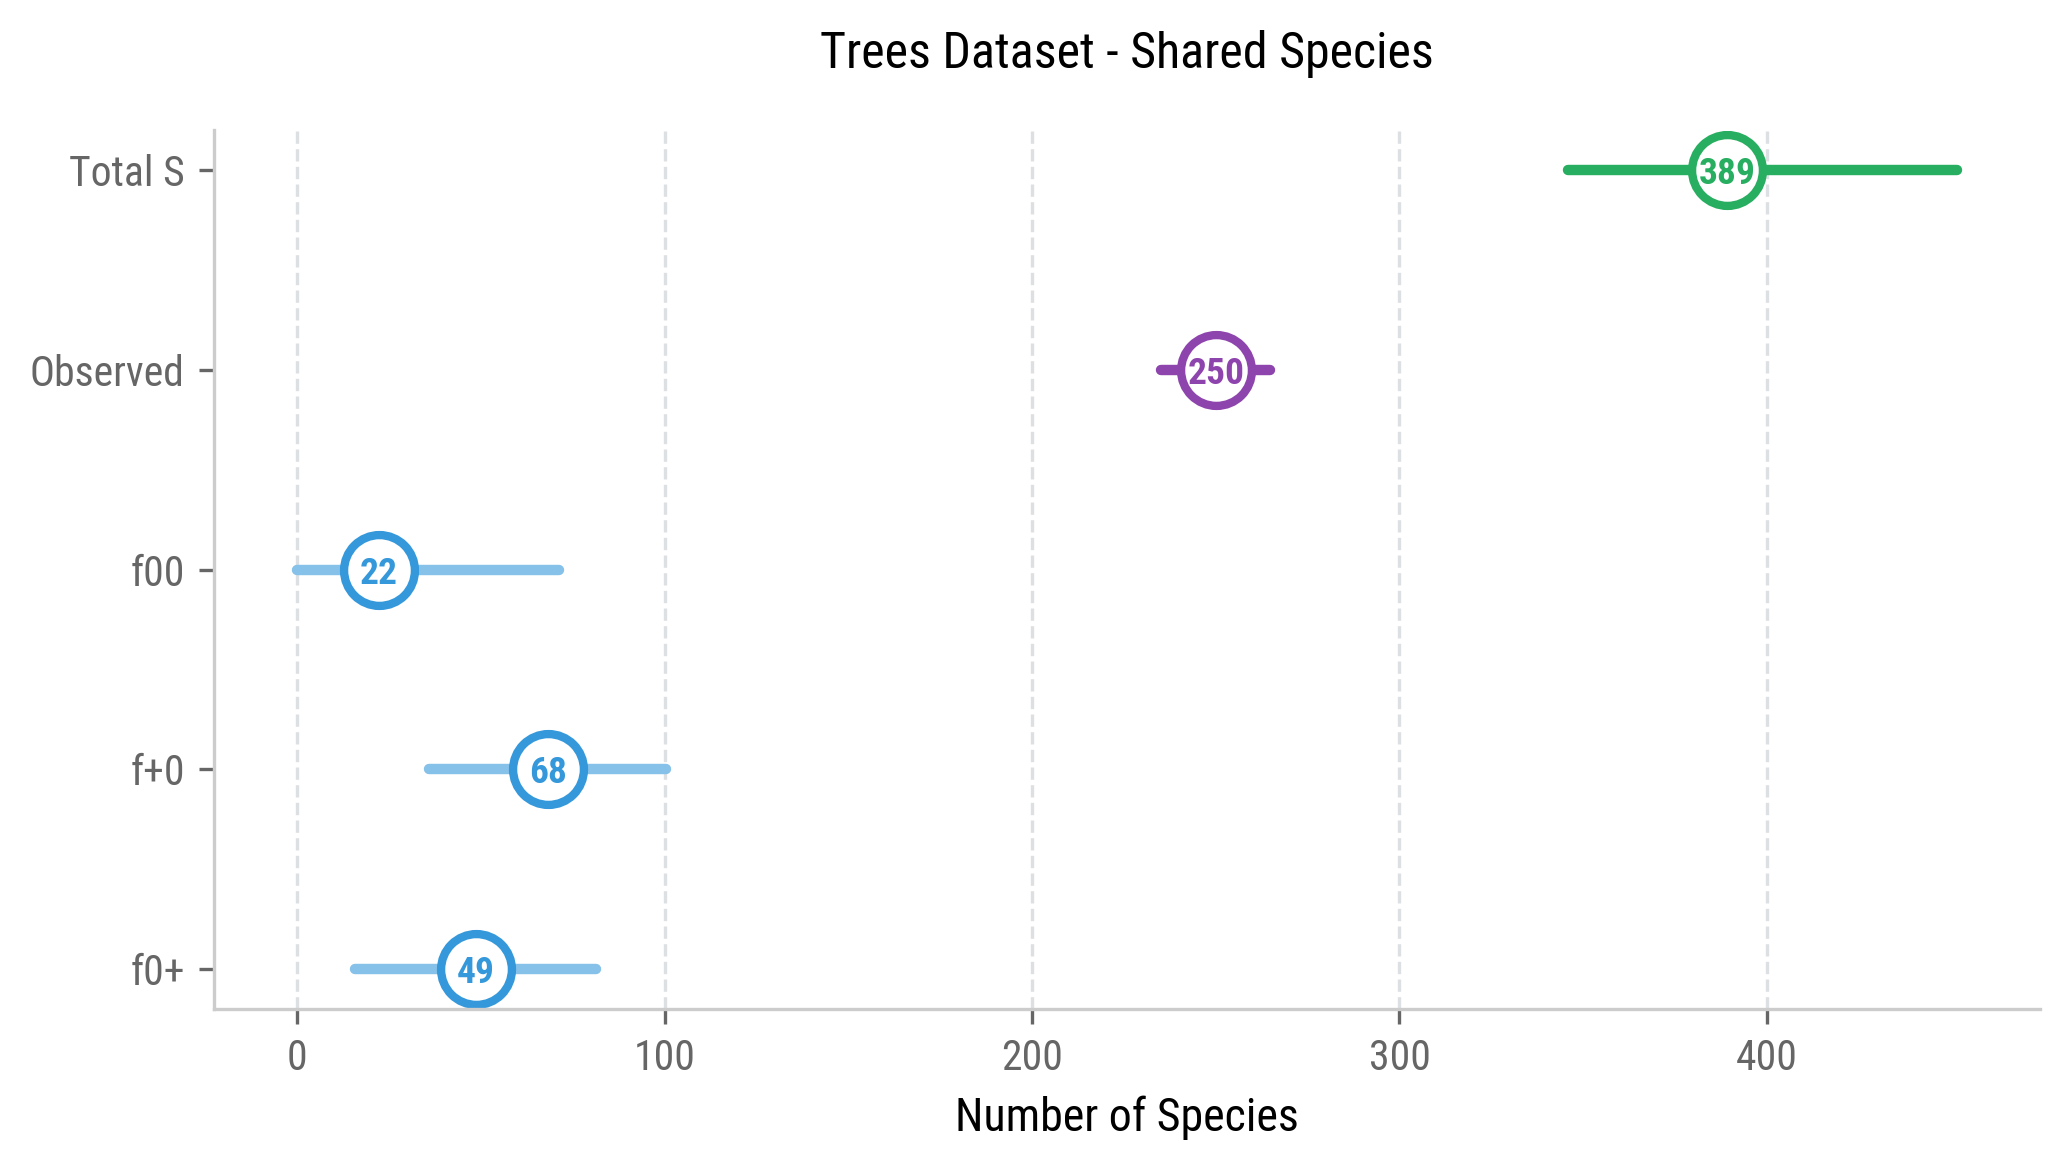

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Roboto Condensed']

def plot_shared_species_forest(df, title=None):
    estimate_color = '#3498db'
    ci_color = '#85c1e9'
    observed_color = '#8E44AD'
    grid_color = '#bdc3c7'
    total_s_color = '#27AE60'
    
    fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    estimates = {
        'f0+': (df.loc[df['name'] == 'f0+', 'Est'].iloc[0],
                df.loc[df['name'] == 'f0+', '95% LCL'].iloc[0],
                df.loc[df['name'] == 'f0+', '95% UCL'].iloc[0]),
        'f+0': (df.loc[df['name'] == 'f+0', 'Est'].iloc[0],
                df.loc[df['name'] == 'f+0', '95% LCL'].iloc[0],
                df.loc[df['name'] == 'f+0', '95% UCL'].iloc[0]),
        'f00': (df.loc[df['name'] == 'f00', 'Est'].iloc[0],
                df.loc[df['name'] == 'f00', '95% LCL'].iloc[0],
                df.loc[df['name'] == 'f00', '95% UCL'].iloc[0]),
        'Observed': (df.loc[df['name'] == 'obs_shared', 'Est'].iloc[0],
                    df.loc[df['name'] == 'obs_shared', '95% LCL'].iloc[0],
                    df.loc[df['name'] == 'obs_shared', '95% UCL'].iloc[0]),
        'Total S': (df.loc[df['name'] == 'total', 'Est'].iloc[0],
                   df.loc[df['name'] == 'total', '95% LCL'].iloc[0],
                   df.loc[df['name'] == 'total', '95% UCL'].iloc[0])
    }
    
    y_positions = range(len(estimates))
    for i, (name, (est, lower, upper)) in enumerate(estimates.items()):
        if name == 'Total S':
            line_color = total_s_color
            marker_color = total_s_color
        elif name == 'Observed':
            line_color = observed_color
            marker_color = observed_color
        else:
            line_color = ci_color
            marker_color = estimate_color
            
        ax.plot([lower, upper], [i, i], '-', color=line_color, linewidth=2.5, 
                solid_capstyle='round')
        
        ax.plot(est, i, 'o', color=marker_color, markersize=17, 
               markeredgewidth=2, markeredgecolor=marker_color, 
               markerfacecolor='white')
        
        ax.text(est, i-0.02, f'{int(round(est))}', ha='center', va='center', 
                color=marker_color, fontsize=9, fontweight='bold')
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(estimates.keys())
    ax.grid(True, axis='x', linestyle='--', alpha=0.5, color=grid_color)
    
    if title:
        ax.set_title(title, fontsize=12, pad=15)
    
    ax.set_xlabel('Number of Species', fontsize=11)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    
    ax.tick_params(axis='both', labelsize=10, colors='#666666')
    
    plt.tight_layout()
    
    return fig, ax

fig, ax = plot_shared_species_forest(df, title="Trees Dataset - Shared Species")
plt.show()